# **Forecasting**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers

## Generación del conjunto para inferencia

In [44]:
df_infe=pd.read_csv('../data/test_2025_01.csv')
print(df_infe.info())
print(df_infe.head())
print(df_infe.describe())
print(df_infe.shape)
features = [column for column in df_infe.columns if column not in ['hour','city_id','precipitacion_h']]
print(features)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7440 entries, 0 to 7439
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city_id            7440 non-null   int64  
 1   hour               7440 non-null   object 
 2   precipitacion_h    7440 non-null   float64
 3   precipitacion_min  7440 non-null   float64
 4   precipitacion_max  7440 non-null   float64
 5   temp_mean          7440 non-null   float64
 6   temp_min           7440 non-null   float64
 7   temp_max           7440 non-null   float64
 8   rhum_mean          7440 non-null   float64
 9   wspd_max           7440 non-null   float64
 10  wspd_min           7440 non-null   float64
 11  wspd_avg           7440 non-null   float64
 12  wdir_avg           7440 non-null   float64
 13  dwpt_avg           7440 non-null   float64
 14  pres_max           7440 non-null   float64
 15  pres_min           7440 non-null   float64
 16  pres_avg           7440 

## Generación de *batches* para inferencia  

In [45]:
def create_inference_batches(csv_path:str,window_size=30):

    df = pd.read_csv(csv_path, parse_dates=["hour"])
    target_col = "precipitacion_h"
    if target_col not in df.columns:
        raise ValueError(f"No se encontró la columna '{target_col}' en {csv_path}.")
    cols_drop = ["city_id", "hour", target_col,'precipitacion_max','precipitacion_min']
    if "Unnamed: 0" in df.columns:
        cols_drop.append("Unnamed: 0")
    inference_batches = {}
    for cid in sorted(df["city_id"].unique()):
        df_c=df[df["city_id"]==cid].sort_values("hour").reset_index(drop=True)
        x=df_c.drop(columns=cols_drop).values
        y=df_c[target_col].values
        X_windows = []
        y_values = []
        for i in range(len(df_c) - window_size):
            X_windows.append(x[i:i+window_size])
            y_values.append(y[i+window_size])
        
        X_city=tf.convert_to_tensor(np.array(X_windows),dtype=tf.float32)
        y_city=tf.convert_to_tensor(np.array(y_values),dtype=tf.float32)
        c_city=tf.convert_to_tensor(np.full(len(X_windows),cid),dtype=tf.int32)
        
        inference_batches[cid]=((X_city,c_city),y_city)
    
    return inference_batches

In [46]:
inference_data=create_inference_batches('../data/test_2025_01.csv')
print(f"Se han creado {len(inference_data)} lotes de inferencia.")

Se han creado 10 lotes de inferencia.


## Carga del modelo


In [47]:
model = tf.keras.models.load_model('../models/checkpoints/model1_rnn.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ C_input             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_latent_space   │ (None, 1, 8)      │         80 │ C_input[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ city_latent_spac… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_input             │ (None, 30, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 8)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 31)    │          0 │ X_input[0][0],    │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn1 (SimpleRNN)    │ (None, 30, 128)   │     20,480 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn2 (SimpleRNN)    │ (None, 128)       │     32,896 │ rnn1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ rnn2[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,757 (627.96 KB)

 Trainable params: 53,585 (209.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,172 (418.64 KB)

## Inferencia por ciudad

In [60]:
(X_city,c_city),y_city = inference_data[0]

In [61]:
X_city.shape

TensorShape([714, 30, 23])

In [62]:
c_city.shape

TensorShape([714])

In [63]:
y_city.shape

TensorShape([714])

In [64]:
y_city

<tf.Tensor: shape=(714,), dtype=float32, numpy=
array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.6     ,  0.16    ,
        0.92    ,  0.      ,  3.24    ,  3.16    ,  3.48    ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
   

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para SOLEDAD: 2.0045


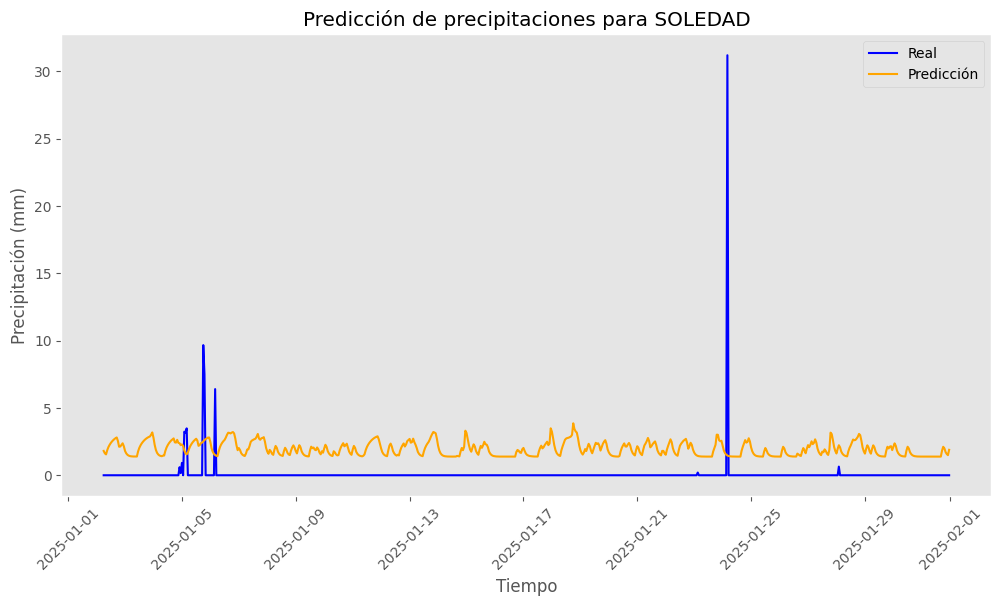

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para CARTAGENA DE INDIAS: 4.7804


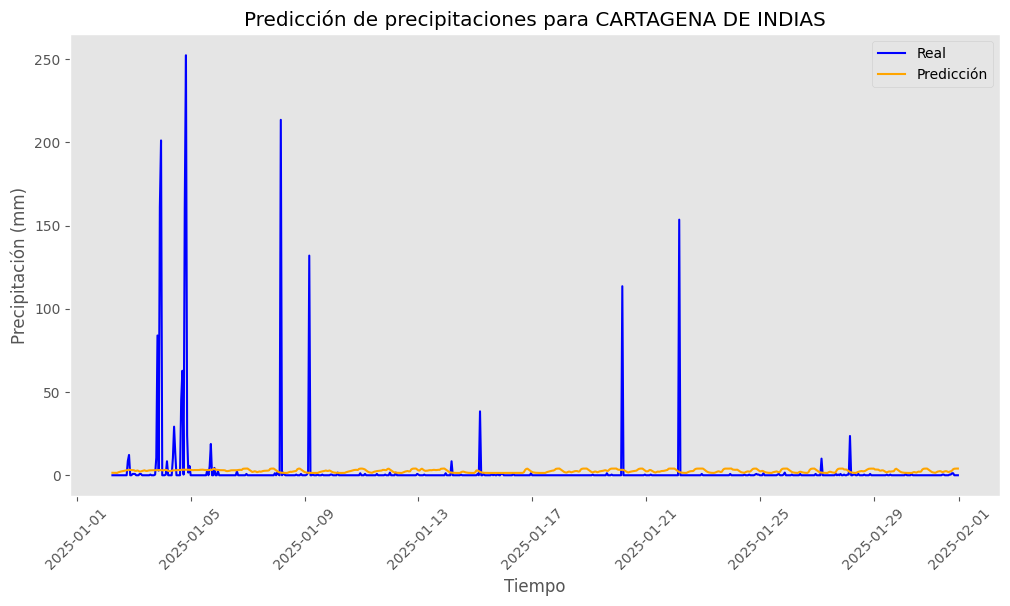

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE para VALLEDUPAR: 2.2778


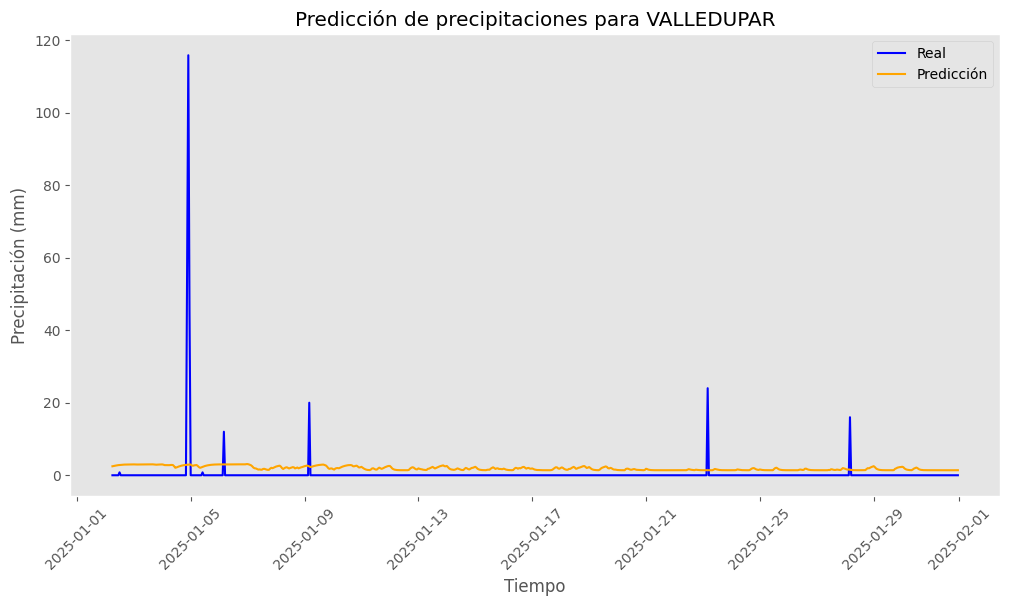

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE para BOGOTA D.C: 3.2724


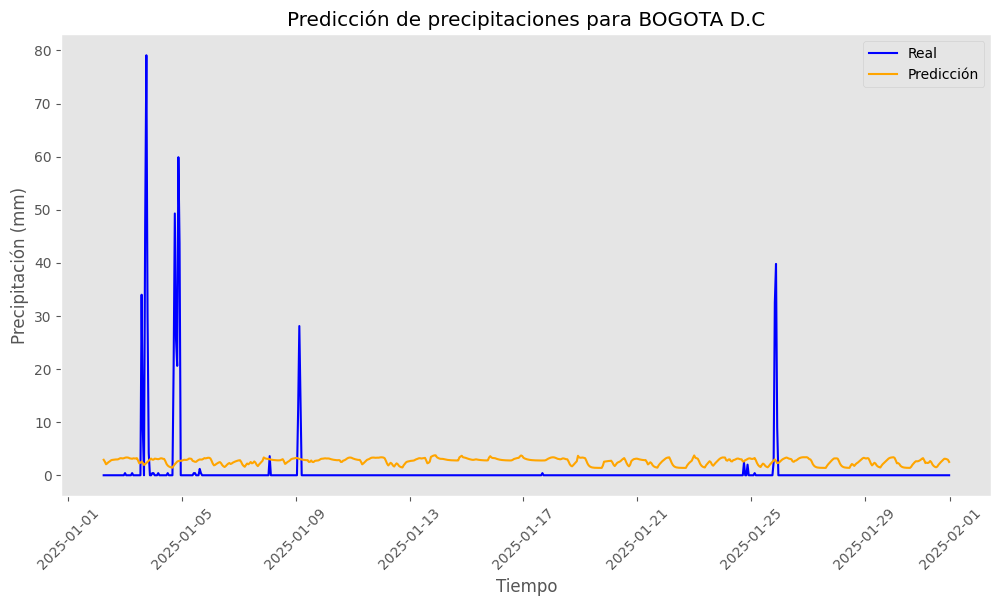

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para NEIVA: 3.8691


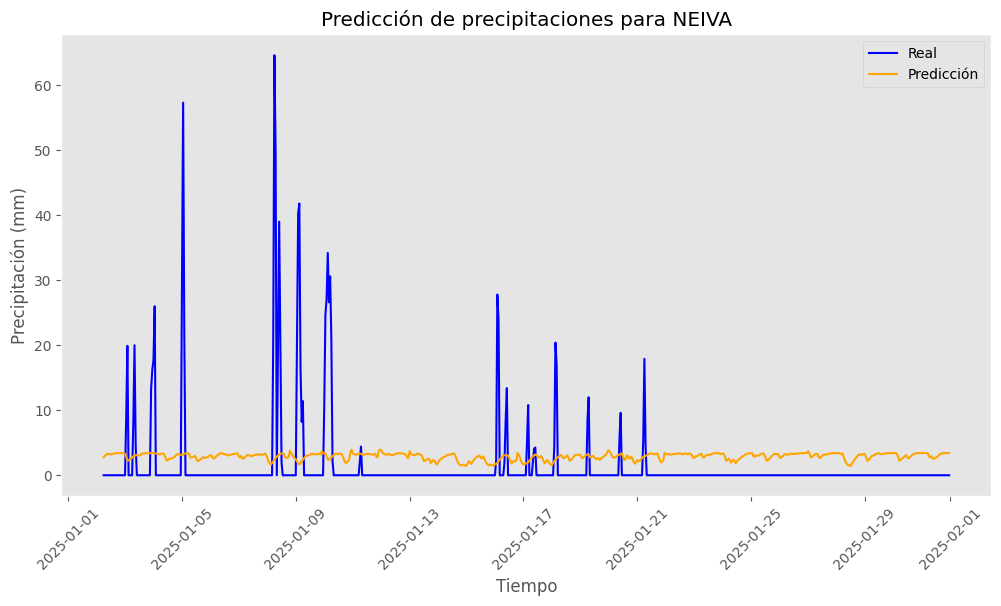

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE para RIOHACHA: 3.0445


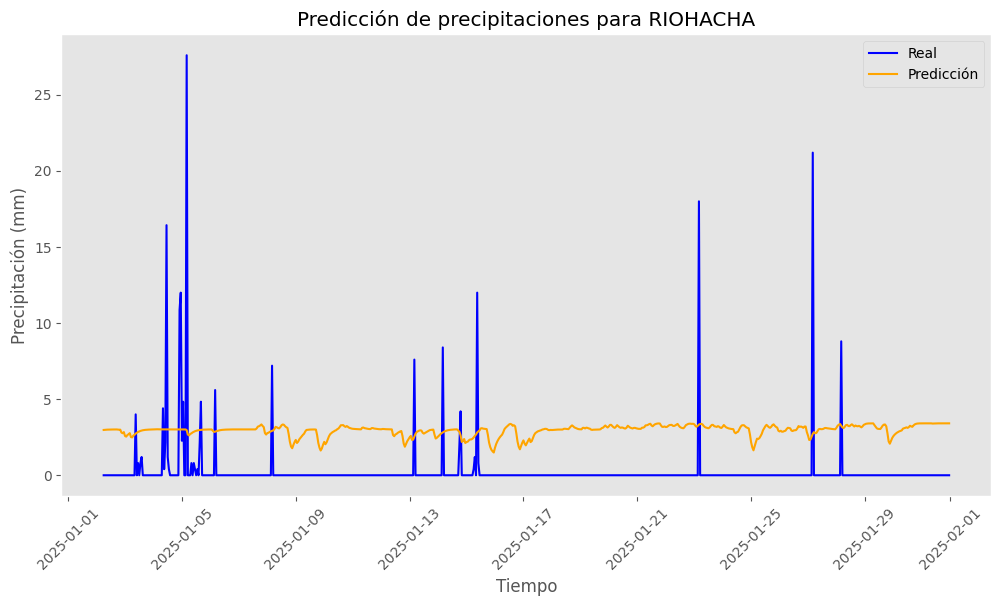

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para PASTO: 6.3112


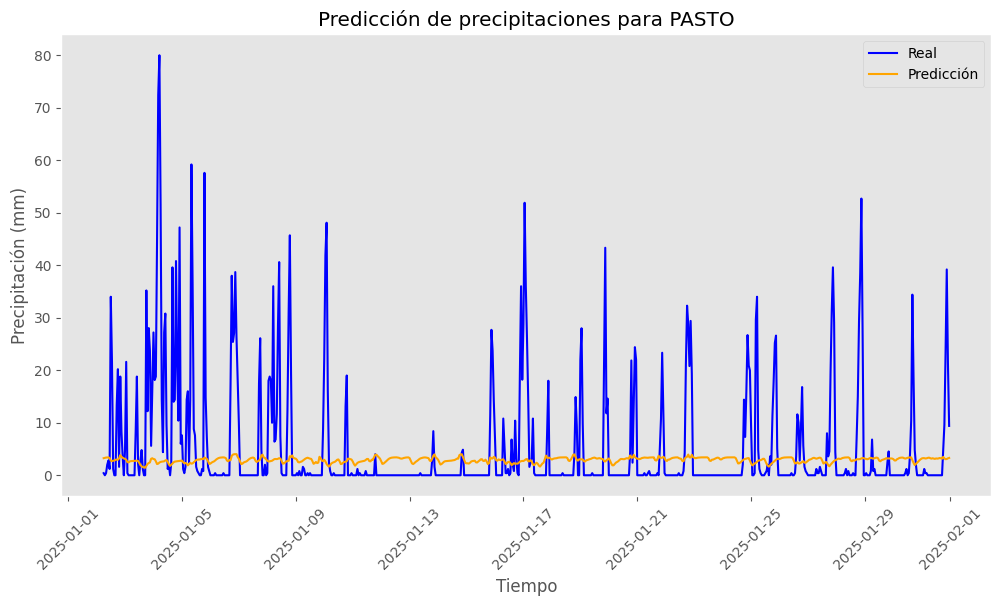

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para CÚCUTA: 4.1723


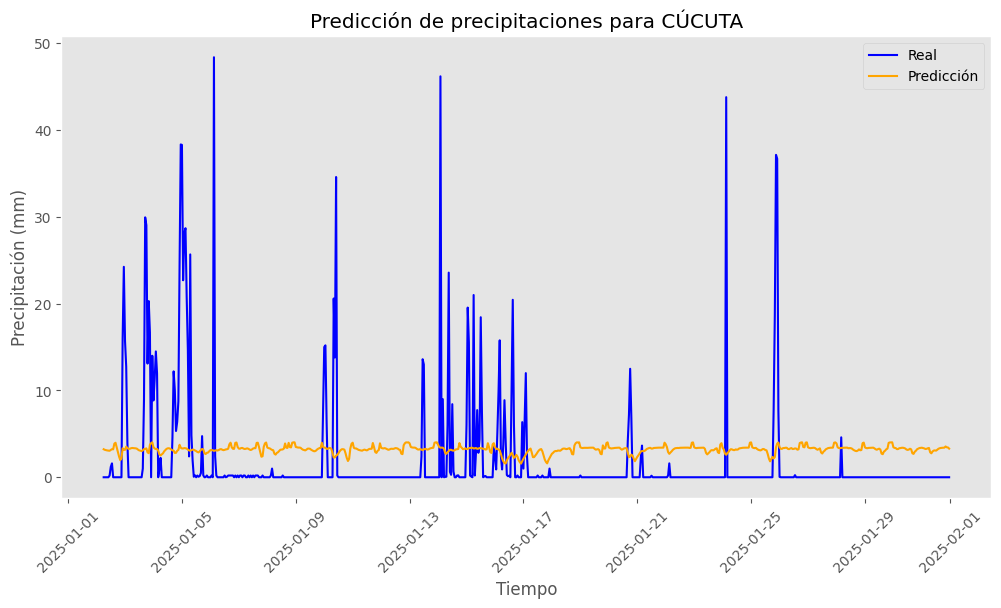

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para ARMENIA: 4.7977


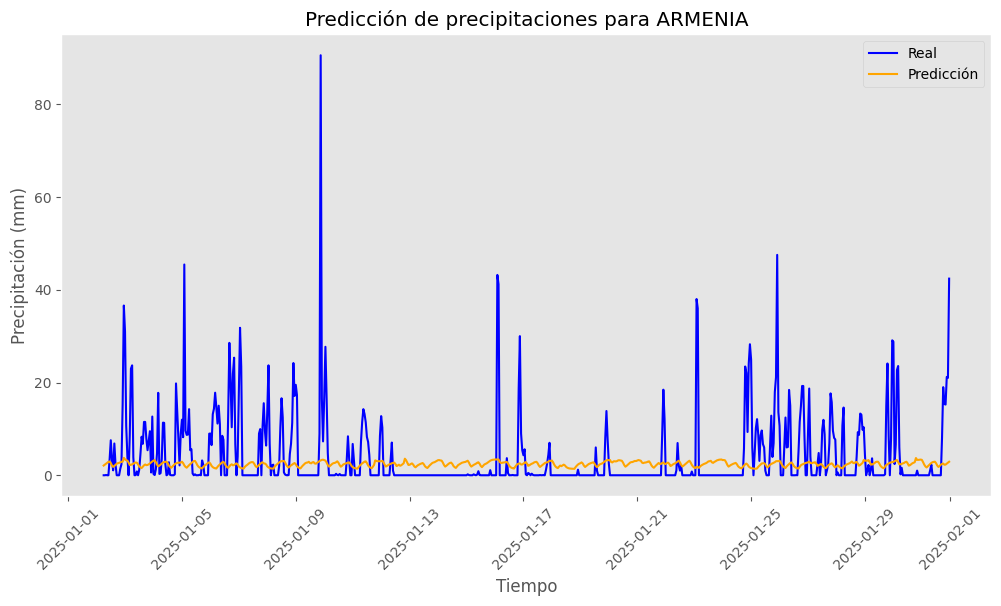

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE para SAN ANDRÉS: 18.9406


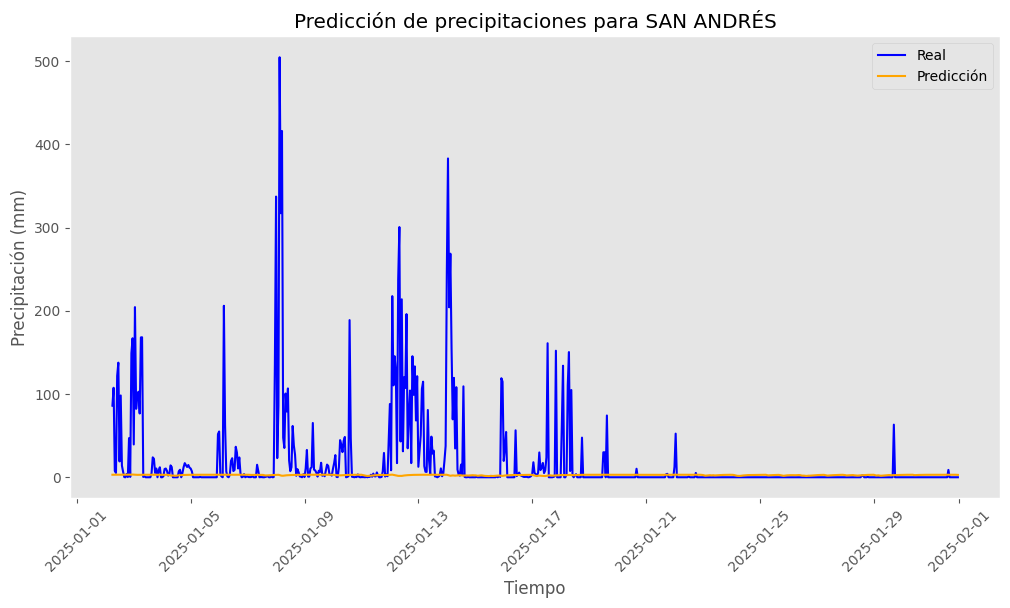

In [76]:
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')
CITIES=['SOLEDAD','CARTAGENA DE INDIAS','VALLEDUPAR','BOGOTA D.C','NEIVA','RIOHACHA','PASTO','CÚCUTA','ARMENIA','SAN ANDRÉS']
for city, id in zip(CITIES, inference_data.keys()):
    (X_city, c_city), y_city = inference_data[id]
    y_pred = model.predict([X_city, c_city])
    mae = mean_absolute_error(y_city.numpy(), y_pred)
    print(f"MAE para {city}: {mae:.4f}")
    n_horas=len(y_city)
    fecha_inicio=pd.Timestamp('2025-01-01 00:00') + pd.Timedelta(hours=30)
    fechas=pd.date_range(start=fecha_inicio, periods=n_horas, freq='h')
    plt.figure(figsize=(12, 6))
    plt.plot(fechas, y_city, label='Real', color='blue')
    plt.plot(fechas, y_pred, label='Predicción', color='orange')
    plt.title(f'Predicción de precipitaciones para {city}')
    plt.xlabel('Tiempo')
    plt.xticks(rotation=45)
    plt.ylabel('Precipitación (mm)')
    plt.legend()
    plt.grid()
    plt.show()